In [17]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def load_image_grayscale(path):
    img = Image.open(path).convert('L')  # Convert to grayscale
    img_np = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img_np

In [15]:
def compute_fft2(image):
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    return fshift

In [124]:
def generate_circular_masks(shape, grid_size, radius, overlap=0.15):
    H, W = shape
    masks = []
    cx, cy = W // 2, H // 2  # center of frequency domain

    spacing = 2 * radius * (1 - overlap)

    x_lin = np.linspace(cx - (grid_size[1] - 1) / 2 * spacing,
                        cx + (grid_size[1] - 1) / 2 * spacing,
                        grid_size[1])
    y_lin = np.linspace(cy - (grid_size[0] - 1) / 2 * spacing,
                        cy + (grid_size[0] - 1) / 2 * spacing,
                        grid_size[0])
    xv, yv = np.meshgrid(x_lin, y_lin)

    Y, X = np.ogrid[:H, :W]
    centers = []

    for i in range(grid_size[0]):  # rows
        for j in range(grid_size[1]):  # columns
            center_x, center_y = int(round(xv[i, j])), int(round(yv[i, j]))
            mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
            masks.append(mask.astype(np.float32))
            centers.append([center_x - cx, center_y - cy])

    centers_px = np.array(centers, dtype=np.int32)[None, :, :]  # (1, N, 2)

    return masks, centers_px


In [108]:
def apply_mask_to_fft(fft_image, mask):
    return fft_image * mask

In [109]:
def compute_ifft2(fft_masked):
    f_ishift = np.fft.ifftshift(fft_masked)
    img_back = np.fft.ifft2(f_ishift)
    return np.abs(img_back)

In [110]:
def show_image_and_spectrum(image, fft_image, title_prefix=""):
    magnitude_spectrum = np.log1p(np.abs(fft_image))

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'{title_prefix}Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title(f'{title_prefix}FFT Magnitude')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [111]:
def visualize_masks_overlay(fft_image, masks, alpha=0.3):
    base = np.log1p(np.abs(fft_image))
    combined_mask = np.zeros_like(base)

    for mask in masks:
        combined_mask += mask

    plt.figure(figsize=(6, 6))
    plt.imshow(base, cmap='gray')
    plt.imshow(combined_mask, cmap='jet', alpha=alpha)
    plt.title("Circular Mask Grid Overlay")
    plt.axis('off')
    plt.show()

In [112]:
def display_low_res_images(images, grid_size):
    rows, cols = grid_size
    fig, axs = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            axs[i, j].imshow(images[idx], cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f'Patch ({i},{j})')
    plt.tight_layout()
    plt.show()


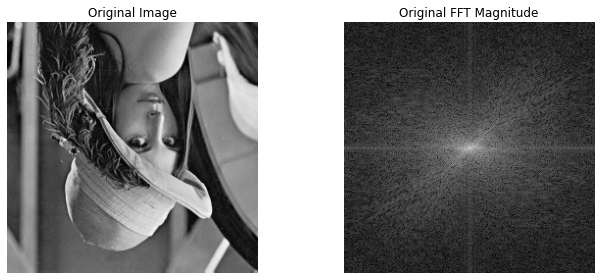

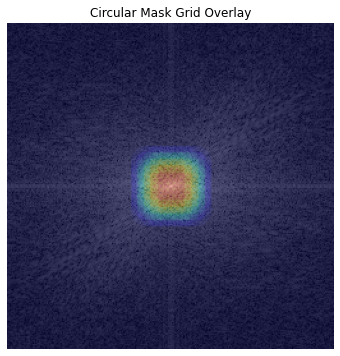

In [125]:
# Load and process image
img = load_image_grayscale('/Users/yenwangcheng/Desktop/Jena/Imip/image_sim.png')
fshift = compute_fft2(img)

# Show original and spectrum
show_image_and_spectrum(img, fshift, title_prefix="Original ")

# Create masks
grid_size = (8, 8)
radius = 14
masks, Ns = generate_circular_masks(img.shape, grid_size, radius, overlap=0.816)

# Visualize masks on spectrum
visualize_masks_overlay(fshift, masks)


In [126]:
Ns[0,:,0],Ns[0, :, 1]

(array([-18, -13,  -8,  -3,   3,   8,  13,  18, -18, -13,  -8,  -3,   3,
          8,  13,  18, -18, -13,  -8,  -3,   3,   8,  13,  18, -18, -13,
         -8,  -3,   3,   8,  13,  18, -18, -13,  -8,  -3,   3,   8,  13,
         18, -18, -13,  -8,  -3,   3,   8,  13,  18, -18, -13,  -8,  -3,
          3,   8,  13,  18, -18, -13,  -8,  -3,   3,   8,  13,  18],
       dtype=int32),
 array([-18, -18, -18, -18, -18, -18, -18, -18, -13, -13, -13, -13, -13,
        -13, -13, -13,  -8,  -8,  -8,  -8,  -8,  -8,  -8,  -8,  -3,  -3,
         -3,  -3,  -3,  -3,  -3,  -3,   3,   3,   3,   3,   3,   3,   3,
          3,   8,   8,   8,   8,   8,   8,   8,   8,  13,  13,  13,  13,
         13,  13,  13,  13,  18,  18,  18,  18,  18,  18,  18,  18],
       dtype=int32))

In [127]:
# Apply masks and inverse FFT
low_res_images = []
for mask in masks:
    masked_fft = apply_mask_to_fft(fshift, mask)
    low_res = compute_ifft2(masked_fft)
    low_res_images.append(low_res)

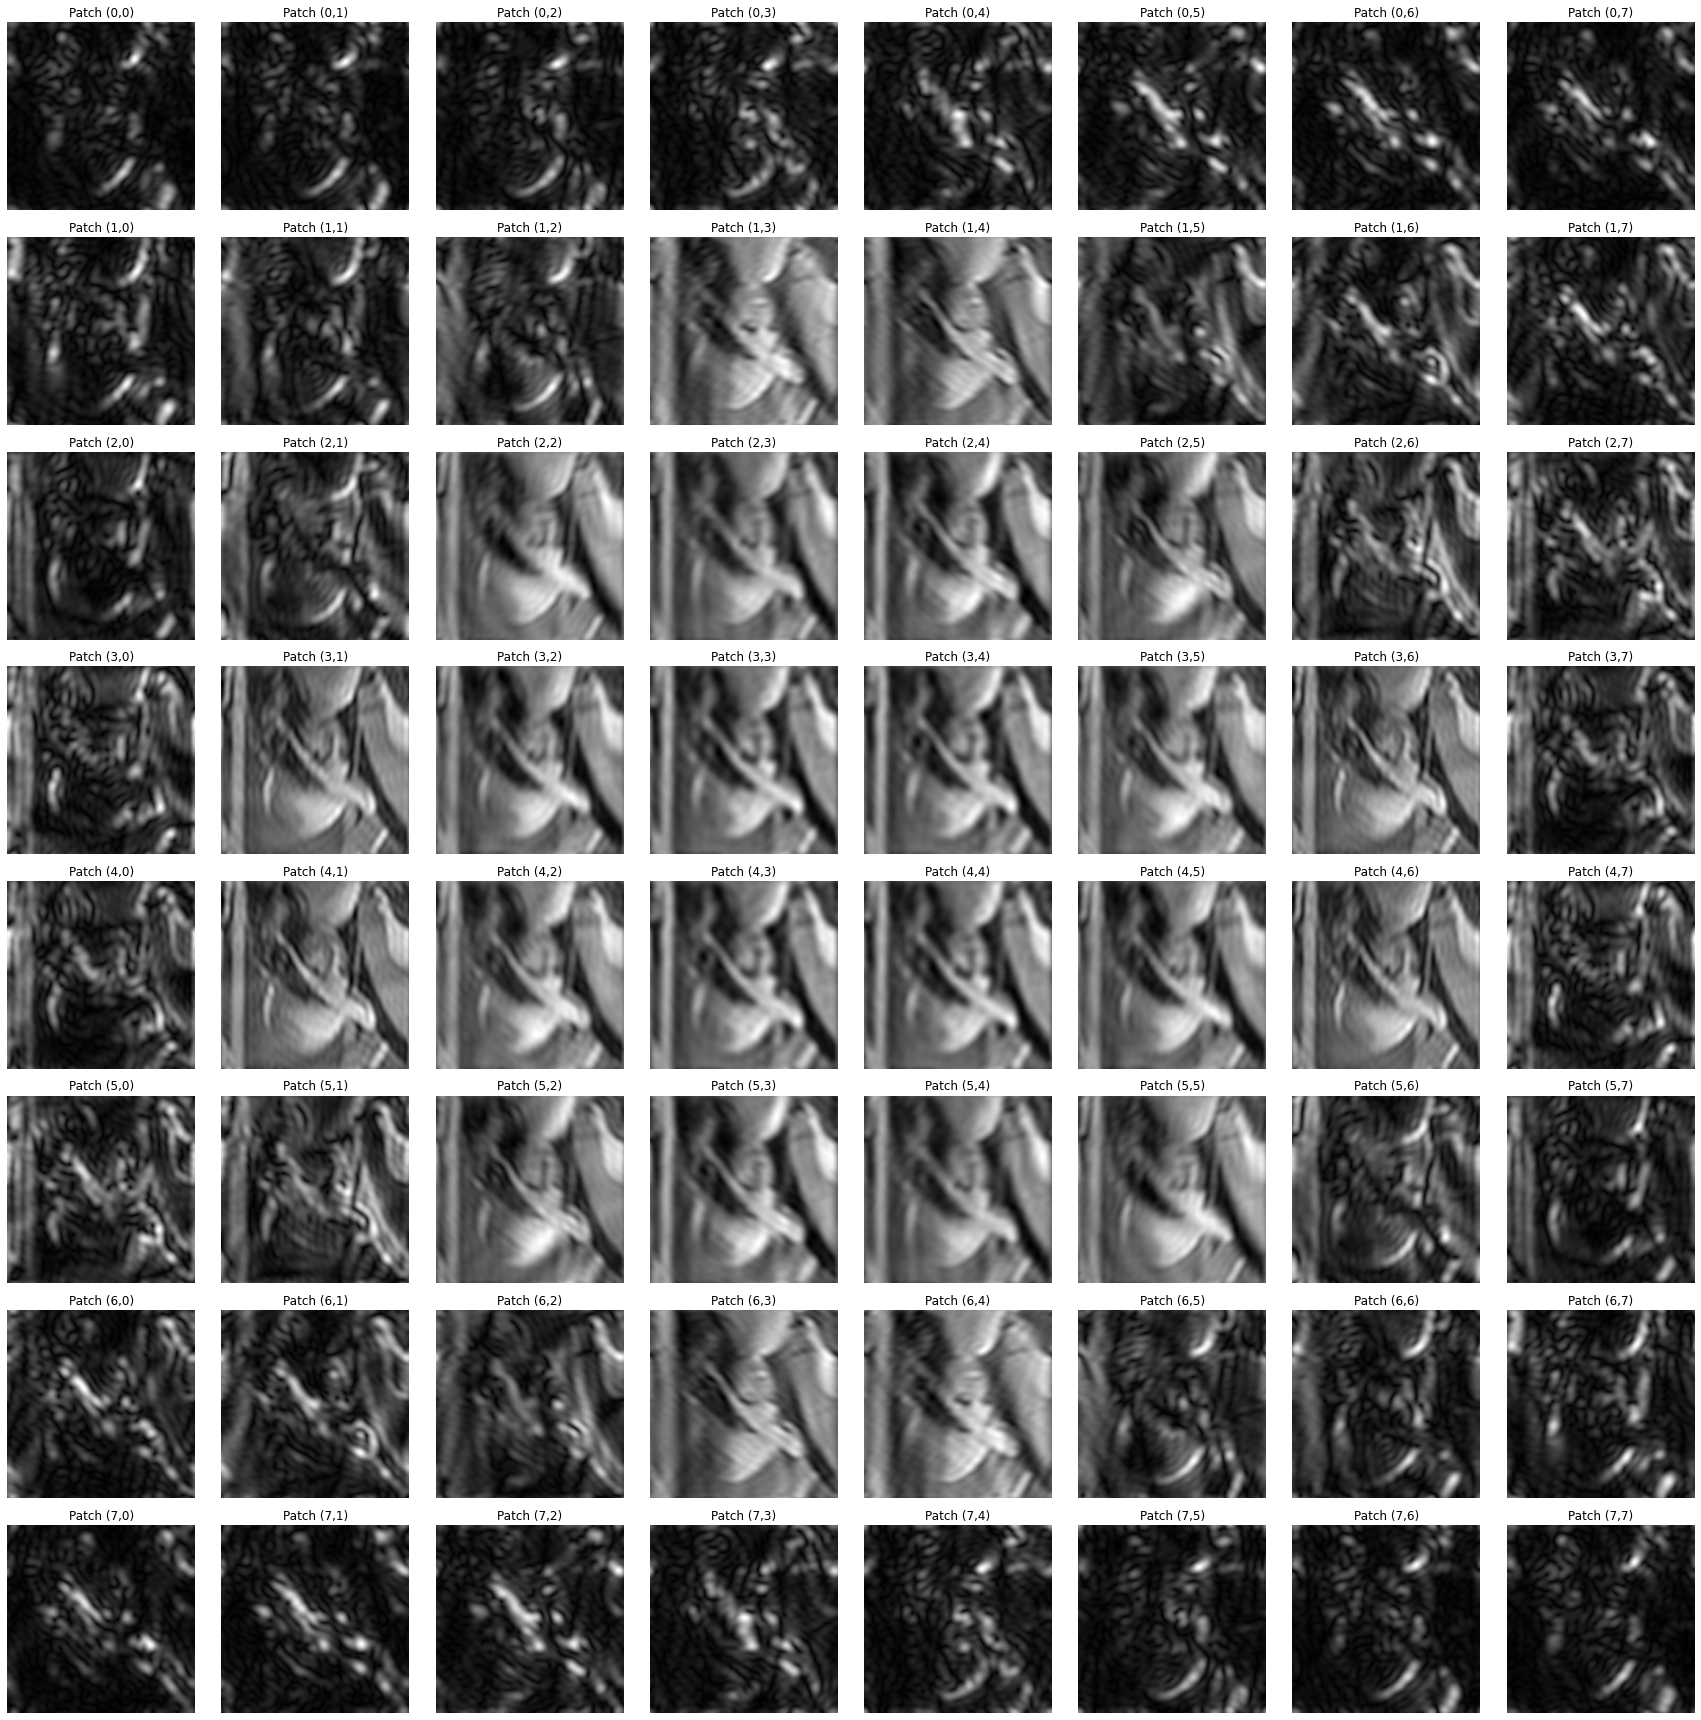

In [128]:
# Display reconstructed images
display_low_res_images(low_res_images, grid_size)

In [129]:
stacked_images = np.stack(low_res_images, axis=-1)
stacked_images.shape

(256, 256, 64)

In [130]:
Ns[0, 4]

array([  3, -18], dtype=int32)

In [136]:
%load_ext autoreload
%autoreload 2
import Main_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# Stepsize 0.01
# Alpha Beta are both 3
O, P, err, scale, Ns = AlterMin(stacked_images, [612,612], Ns, {})

| iter |  rmse    |
--------------------
|  0   | inf |
|  1   | 1.51e+12 |
|  2   | 9.81e+10 |
|  3   | 1.03e+10 |
|  4   | 4.22e+09 |
|  5   | 2.26e+09 |
|  6   | 1.39e+09 |
|  7   | 9.24e+08 |
|  8   | 6.49e+08 |
|  9   | 4.74e+08 |
| 10   | 3.57e+08 |
| 11   | 2.76e+08 |
| 12   | 2.18e+08 |
| 13   | 1.75e+08 |
| 14   | 1.43e+08 |
| 15   | 1.19e+08 |
| 16   | 9.99e+07 |
| 17   | 8.49e+07 |
| 18   | 7.28e+07 |
| 19   | 6.30e+07 |
| 20   | 5.49e+07 |
| 21   | 4.82e+07 |
| 22   | 4.27e+07 |
| 23   | 3.79e+07 |
| 24   | 3.39e+07 |
| 25   | 3.05e+07 |
| 26   | 2.76e+07 |
| 27   | 2.50e+07 |
| 28   | 2.28e+07 |
| 29   | 2.08e+07 |
| 30   | 1.91e+07 |
| 31   | 1.76e+07 |
| 32   | 1.63e+07 |
| 33   | 1.51e+07 |
| 34   | 1.40e+07 |
| 35   | 1.31e+07 |
| 36   | 1.22e+07 |
| 37   | 1.14e+07 |
| 38   | 1.07e+07 |
| 39   | 1.01e+07 |
| 40   | 9.47e+06 |
| 41   | 8.93e+06 |
| 42   | 8.43e+06 |
| 43   | 7.98e+06 |
| 44   | 7.56e+06 |
| 45   | 7.17e+06 |
| 46   | 6.81e+06 |
| 47   | 6.48e+06 |
| 48